In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generación de grafeno ##

#### La red podría formarse con la base de dos vectores: ####
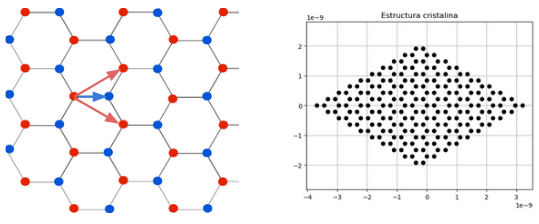

#### Pero resulta conveniente, para tener una lámina rectangular que "pegue bien" con los bordes de la caja de simulación, construirla de la siguiente manera: ####
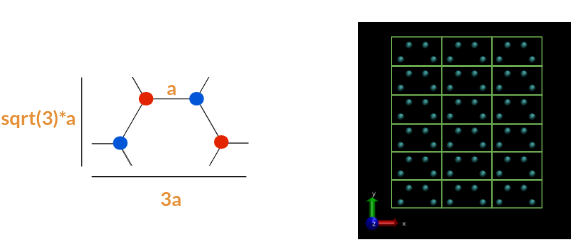

In [2]:
def grafeno(a, unix, uniy): 
    
    # a:Distancia entre carbonos [Ang].
    # unix: Cantidad de unidades repetitivas en x, -1.
    # uniy: Cantidad de unidades repetitivas en y, -1.
    
    N = 4 * unix * uniy
    mposc = np.zeros((N, 2))
    s = 0
    vert = a * np.sqrt(3) / 2
    
    for p in range(uniy):
        for q in range(unix):
            mposc[s, 0] = a / 2. + 3. * a * (q - 1)
            mposc[s, 1] = vert / 2. + 2. * vert * (p - 1)
            mposc[s + 1, 0] = a + 3. * a * (q - 1)
            mposc[s + 1, 1] = vert / 2. + vert + 2. * vert * (p - 1)
            mposc[s + 2, 0] = 2. * a + 3. * a * (q - 1)
            mposc[s + 2, 1] = vert / 2. + vert + 2. * vert * (p - 1)
            mposc[s + 3, 0] = a / 2. + 2. * a + 3. * a * (q - 1)
            mposc[s + 3, 1] = vert / 2. + 2. * vert * (p - 1)
            s += 4
    IndicesPositivos = np.all(mposc >= 0, axis=1) #Para no generar conflictos con LAMMPS, me quedo solo con posiciones positivas de Carbono
    mposc = mposc[IndicesPositivos]
    return mposc

### Se define la siguiente unidad repetitiva para evitar problemas con las PBC en la caja de simulación ###

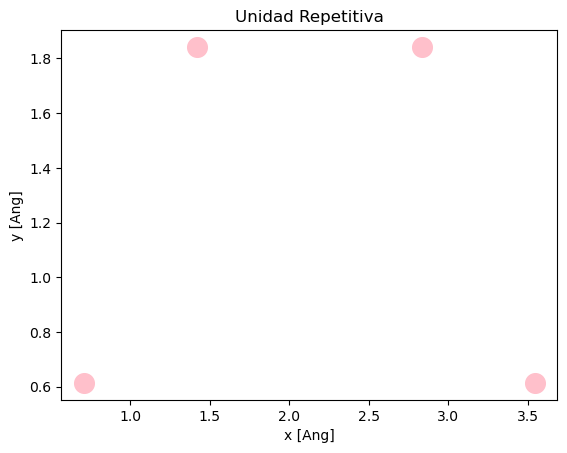

In [3]:
UnidadRepetitiva = grafeno(1.418,2,2)
plt.scatter(UnidadRepetitiva[:,0], UnidadRepetitiva[:,1], color='pink',marker='o',s=200)
plt.title('Unidad Repetitiva')
plt.xlabel('x [Ang]')
plt.ylabel('y [Ang]')
plt.show()

In [4]:
mposc=grafeno(1.418,8,14)

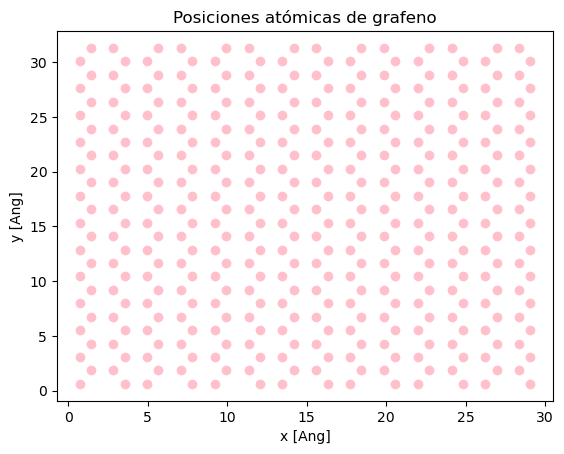

In [5]:
plt.scatter(mposc[:,0], mposc[:,1], color='pink')
plt.title('Posiciones atómicas de grafeno')
plt.xlabel('x [Ang]')
plt.ylabel('y [Ang]')
plt.show()

#### Genero el archivo input para LAMMPS, considerando la estructura de archivo que sale al generarla con TopoTools (VMD) ####

In [6]:
def generar_archivo(mposc,zlo,zhi):
#PBC BOX
    xlo = 0
    xhi = max(mposc[:, 0])+0.614
    ylo = 0
    yhi = max(mposc[:, 1])

    with open("atomic_positions.data", "w") as f:
        f.write("LAMMPS data file. CGCMM style. atom_style atomic generated by VMD/TopoTools v1.7 on Wed Feb 21 10:28:38 -03 2024")
        f.write(f"{len(mposc)} atoms\n")
        f.write("0 bonds\n")
        f.write("0 angles\n")
        f.write("0 dihedrals\n")
        f.write("0 impropers\n")
        f.write("1 atom types\n")
        f.write("0 bond types\n")
        f.write("0 angle types\n")
        f.write("0 dihedral types\n")
        f.write("0 improper types\n")
        f.write(f"0 {xhi:.6f} xlo xhi\n")
        f.write(f"0 {yhi:.6f} ylo yhi\n")
        f.write(f"{zlo:.6f} {zhi:.6f} zlo zhi\n\n")
        f.write("# Pair Coeffs\n#\n")
        f.write("# 1  CA\n\n")
        f.write("Masses\n\n")
        f.write("1 12.010700 # CA\n\n")
        f.write("Atoms # atomic\n\n")

        atom_type = 1  
        for i, pos in enumerate(mposc, start=1):
            if np.shape(mposc)[1] == 2:
                x, y = pos
                f.write(f"{i} {atom_type} {x:.6f} {y:.6f} 0.0\n")
            elif np.shape(mposc)[1] == 3:
                x, y, z = pos
                f.write(f"{i} {atom_type} {x:.6f} {y:.6f} {z:.6f} 0.0\n")
        return

## Generación de Grafito: ## 

In [7]:
def grafito(apilamiento, a, c, unix, uniy, grafenos):
    
    # apilamiento: 0 = AA , 1 = AB
    # a = Dist entre carbonos (eje x)
    # c = Distancia interplanar
    # unix: Cantidad de unidades repetitivas en x, -1.
    # uniy: Cantidad de unidades repetitivas en y, -1.
    # grafenos: Cantidad de laminas
    
    N = 4 * unix * uniy * grafenos
    mposc = np.zeros((N, 3))
    s = 0
    h = c / 2.0
    vert = a * np.sqrt(3) / 2
    
    if apilamiento == 0:  # Apilamiento A-A
        for r in range(1, grafenos + 1):
            for p in range(uniy):
                for q in range(unix):
                    mposc[s, 0] = a / 2.0 + 3.0 * a * q
                    mposc[s, 1] = vert / 2.0 + 2.0 * vert * p
                    mposc[s, 2] = h
                    mposc[s + 1, 0] = a + 3.0 * a * q
                    mposc[s + 1, 1] = vert / 2.0 + vert + 2.0 * vert * p
                    mposc[s + 1, 2] = h
                    mposc[s + 2, 0] = 2.0 * a + 3.0 * a * q
                    mposc[s + 2, 1] = vert / 2.0 + vert + 2.0 * vert * p
                    mposc[s + 2, 2] = h
                    mposc[s + 3, 0] = a / 2.0 + 2.0 * a + 3.0 * a * q
                    mposc[s + 3, 1] = vert / 2.0 + 2.0 * vert * p
                    mposc[s + 3, 2] = h
                    s += 4
            h += c
    
    elif apilamiento == 1:  # Apilamiento A-B
        for r in range(1, grafenos + 1):
            for p in range(uniy):
                for q in range(unix):
                    mposc[s, 0] = a / 2.0 + 3.0 * a * q - (r - 1) * a
                    mposc[s, 1] = vert / 2.0 + 2.0 * vert * p
                    mposc[s, 2] = h
                    mposc[s + 1, 0] = a + 3.0 * a * q - (r - 1) * a
                    mposc[s + 1, 1] = vert / 2.0 + vert + 2.0 * vert * p
                    mposc[s + 1, 2] = h
                    mposc[s + 2, 0] = 2.0 * a + 3.0 * a * q - (r - 1) * a
                    mposc[s + 2, 1] = vert / 2.0 + vert + 2.0 * vert * p
                    mposc[s + 2, 2] = h
                    mposc[s + 3, 0] = a / 2.0 + 2.0 * a + 3.0 * a * q - (r - 1) * a
                    mposc[s + 3, 1] = vert / 2.0 + 2.0 * vert * p
                    mposc[s + 3, 2] = h
                    s += 4
            h += c
    return mposc

In [8]:
a = 1.418  # Distancia entre carbonos [Ang]
unix = 8  # Número de unidades en x - 1
uniy = 14  # Número de unidades en y - 1
grafenos = 5
c = 6.17
mposcAA = grafito(apilamiento=0, a=a, c=c, unix=unix, uniy=uniy, grafenos=grafenos)
mposcAB = grafito(apilamiento=1, a=a, c=c, unix=unix, uniy=uniy, grafenos=grafenos)

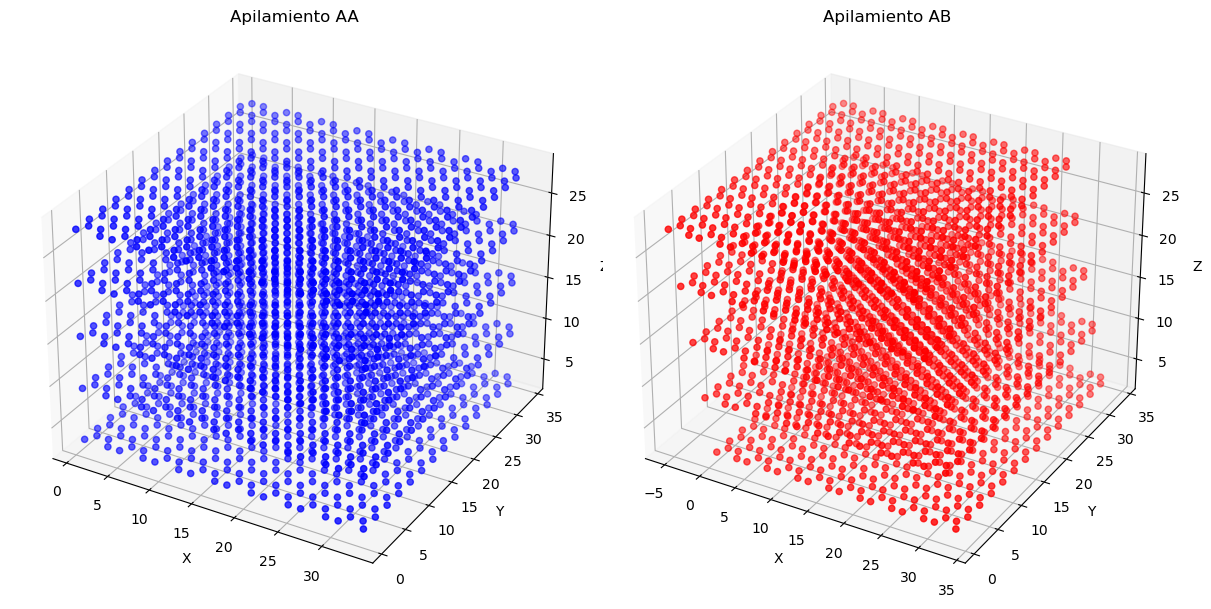

In [9]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# Subgráfico para apilamiento AA
ax1 = fig.add_subplot(121, projection='3d')
x1, y1, z1 = mposcAA[:, 0], mposcAA[:, 1], mposcAA[:, 2]
ax1.scatter(x1, y1, z1, c='b', marker='o')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Apilamiento AA')

# Subgráfico para apilamiento AB
ax2 = fig.add_subplot(122, projection='3d')
x2, y2, z2 = mposcAB[:, 0], mposcAB[:, 1], mposcAB[:, 2]
ax2.scatter(x2, y2, z2, c='r', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Apilamiento AB')

plt.tight_layout()
plt.show()

In [11]:
generar_archivo(mposcAA,zlo=-10,zhi=10)